# Introduction

In this notebook I am curious about predicting the probability of a swing and miss given some standard data, including pitch type, velocity, spin rate, etc. This seems fairly straightforward but there are several approaches we can take to solving this problem. We will consider several of those here.

# Setup

In [6]:
import numpy as np
import pandas as pd

import scipy.stats as stats
import statsmodels.api as sm
from   patsy import dmatrices

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({"font.family":"Arial", 
                     "font.size": 8 ,
                     "axes.labelweight": "bold",
                     "axes.titleweight": "bold",
                     "legend.frameon": False,
                     "text.latex.preamble": r'\boldmath'})

# Define colors
red     = np.divide((232, 24, 40),255)
blue    = np.divide((0, 45, 114),255)
skyblue = np.divide((86, 180, 233),255)
blue_cb = np.divide((0, 114, 178),255)
green   = np.divide((0, 158, 115),255)
pink    = np.divide((204, 121, 167),255)
orange  = np.divide((230, 159, 0),255)
grey    = (.5, .5, .5) 

# Load data

In [7]:
from pathlib import Path

data = pd.read_csv(Path("data/SwingAndMiss/SwingAndMiss_Train.csv"),low_memory=False)
data.sample(5)  

,GameDate,Season,GameNumber,GameSeqNum,DayNight,Venue,Inning,TopInning,PAOfInning,PitchOfPA,...,ReleaseSpeed,PitchBreakVert,PitchBreakHorz,SpinRate,PlateLocX,PlateLocZ,PitchType,PitchResult,SwingFL,VideoLink
928880,2019-06-17,2019,566601,249,Night,Busch Stadium,8,BOTTOM,1,1,...,91.335999,8.74069,1.881100,2203.260010,-0.564750,2.79430,FB,Swinging strike,1,NaN
982960,2019-07-03,2019,566029,16,Night,Citi Field,1,TOP,3,1,...,84.602898,4.87127,9.771390,2165.580078,1.569050,2.45084,SI,Called ball,0,NaN
317616,2018-06-26,2018,530593,100,Night,Comerica Park,3,TOP,3,2,...,87.735497,7.75022,7.862580,1995.699951,1.199960,2.36728,FB,Ball in play,1,https://coach-video.mlb.com/mlb/2018/06/27/70d...
920182,2019-06-15,2019,565450,281,Night,Coors Field,6,BOTTOM,2,2,...,92.773201,7.47507,-0.201266,2498.110107,0.273287,3.00269,FB,Swinging strike,1,NaN
1197683,2019-09-04,2019,566637,42,Night,Busch Stadium,2,TOP,2,6,...,94.381203,9.26459,-4.128750,2064.179932,-1.515270,2.56935,FB,Ball in play,1,NaN


# Exploratory Data Analysis
Let's start by looking at the velocity and spin rate of the pitches in the data since those are often two of many things that we care about. 

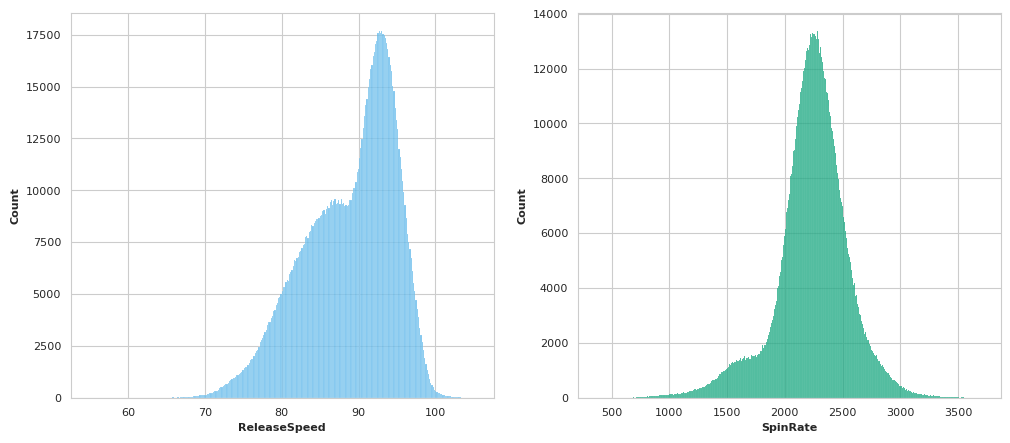

In [8]:
columns = ["ReleaseSpeed", "SpinRate"]
colors  = [skyblue, green]
with sns.axes_style("whitegrid"):
    # Make figure
    fig, allax = plt.subplots(1,len(columns))#,sharey=True)#sharex=True)
    fig.set_size_inches(12,5)
    
    for (col, ax, clr) in zip(columns, allax.ravel(), colors):
        sns.histplot(ax=ax, data=data,x=col,color=clr)

Now let's condition on pitch type.

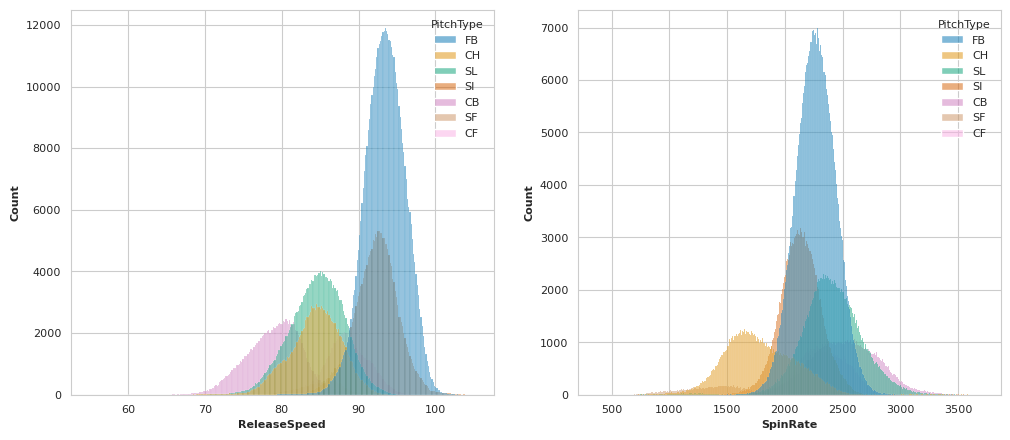

In [9]:
columns = ["ReleaseSpeed", "SpinRate"]
with sns.axes_style("whitegrid"):
    # Make figure
    fig, allax = plt.subplots(1,len(columns))#,sharey=True)#sharex=True)
    fig.set_size_inches(12,5)
    for (col, ax) in zip(columns, allax.ravel()):
        sns.histplot(ax=ax, data=data,x=col,hue="PitchType",palette="colorblind")

Now let's get really ugly and condition on pitcher. 

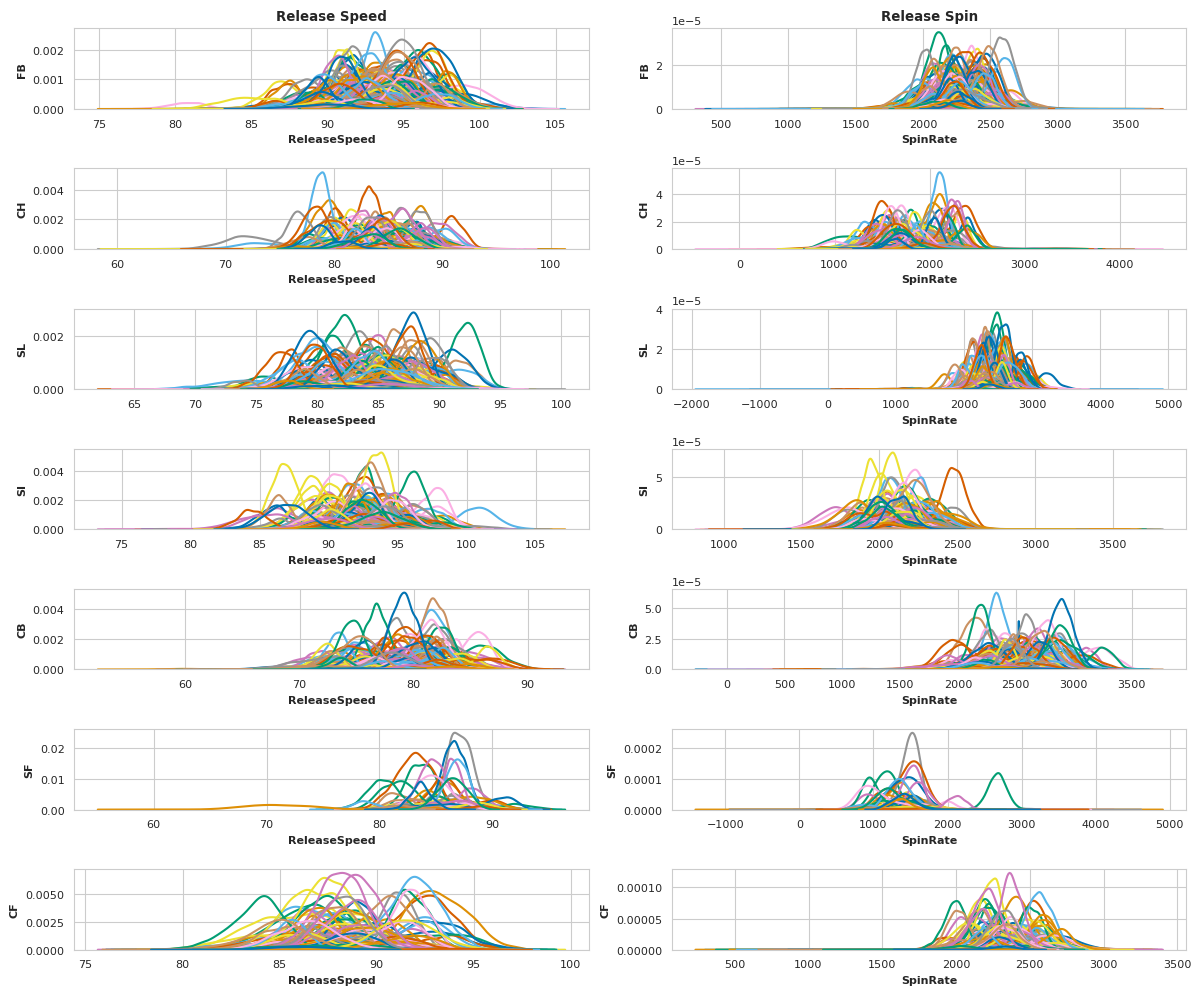

In [10]:
columns = ["ReleaseSpeed", "SpinRate"]
pitches = data.PitchType.unique()
with sns.axes_style("whitegrid"):
    # Make figure
    fig, ax = plt.subplots(len(pitches),len(columns))#,sharey=True)#sharex=True)
    fig.set_size_inches(12,10)
    for ii, pitch in enumerate(pitches):
        _local = data.loc[data.PitchType.isin([pitch]),:].copy()
        for jj, col in enumerate(columns):
            # Conditioned by pitcher
            sns.kdeplot(ax=ax[ii,jj], data=_local,x=col,hue="PitcherID",palette="colorblind",legend=False,warn_singular=False)
            ax[ii,jj].set_ylabel(pitch)
            
ax[0,0].set_title("Release Speed",fontweight="bold")
ax[0,1].set_title("Release Spin",fontweight="bold")
plt.tight_layout()

This isn't that informative as is, but it does give us an idea of how the data are being generated. It appears that each pitch type from each pitcher is drawn from some $\mathcal{N}( \mu, \sigma)$. This gives us a clue of how we might model the data. For example, we might say assume the spin and velocity are drawn from some distribution, $\mathcal{N}( \mu, \sigma)$ , where the parameters of that distribution are also $\mathcal{N}( \mu, \sigma)$. For now we will just put this idea in our back pocket and look at a few other pitch parameters. 

In [11]:
# Pitches in dataset
data.PitchType.value_counts()

FB    486330
SL    215435
SI    214615
CH    141858
CB    130988
CF     80016
SF     18831
Name: PitchType, dtype: int64

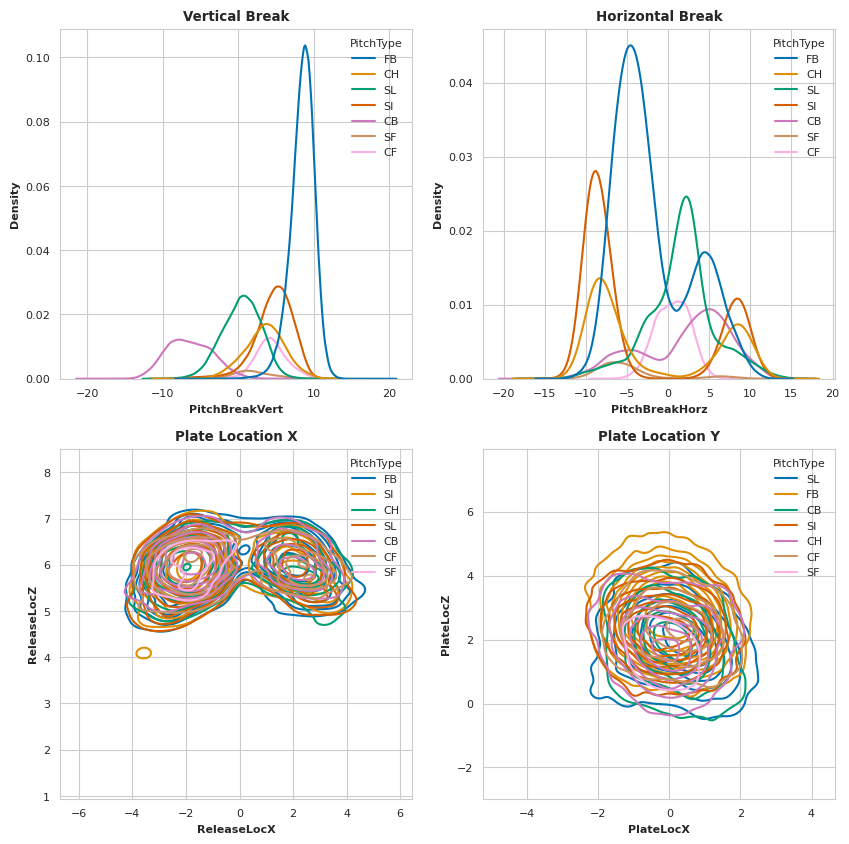

In [12]:
columns = ["PitchBreakVert","PitchBreakHorz",["ReleaseLocX", "ReleaseLocZ"], ["PlateLocX", "PlateLocZ"]]
# columns = ["PitchBreakVert","PitchBreakHorz","ReleaseLocX", "ReleaseLocZ", "PlateLocX", "PlateLocZ"]
titles = ["Vertical Break", "Horizontal Break", "Plate Location X", "Plate Location Y"]
with sns.axes_style("whitegrid"):
    # Make figure
    fig, allax = plt.subplots(2,2)#,sharey=True)#sharex=True)
    fig.set_size_inches(10,10)
    for (col, ax, title) in zip(columns, allax.ravel(), titles):
        if len(col) == 2: 
            # The kde plots take forever if there is too much data so let's create a smaller version thats sampled
            sns.kdeplot(ax=ax, data=data.sample(50_000),x=col[0], y=col[1],hue="PitchType",palette="colorblind")
        else:
            sns.kdeplot(ax=ax,data=data,x=col,hue="PitchType",palette="colorblind")
        ax.set_title(title)

# Approach 1: Regression

Let's start with the simplest approach and use an extension of a logistic regression model to estimate the outcome of each pitch given the input parameters. We need to get the data prepared for our analysis. 

In [13]:
data.PitchResult.value_counts()

Called ball        463186
Foul ball          231212
Ball in play       223709
Called strike      214423
Swinging strike    140643
Foul tip            11412
Hit batter           3488
Name: PitchResult, dtype: int64

We will rename foul tip to foul ball since it does not really matter for this analysis. Additionally we are going to remove `hit batter` since it adds a whole new category for prediction that does not really add value to our predictions. 

In [14]:
# Rename foul tip
data.loc[data.PitchResult.isin(["Foul tip"]),"PitchResult"] = "Foul ball"

# Keep only results of interest
pitch_result_to_keep = ['Ball in play', 'Called strike', 'Foul ball', 'Called ball', 'Swinging strike']
trim = data.loc[data.PitchResult.isin(pitch_result_to_keep),:].copy()

# Factorize pitch result
pitch_result_factorized, pitch_result_values = pd.factorize(trim.PitchResult)
pitch_result_dict = {"{}".format(aa):bb for aa,bb in zip(np.arange(0,len(pitch_result_values)), pitch_result_values)}
trim["PitchResultFactorized"] = pitch_result_factorized


Train/test split directly so we can still use patsy for our design matrices. 

In [15]:
# Train test split - We will implement our own version since we will use patsy for our statsmodel implementation
test_idx = np.random.choice(trim.index,round(len(trim)*.2))
train_idx = np.array(list(set(trim.index.tolist()) - set(test_idx)))

# # Get train and test dataframes
# data_train = trim.loc[train_idx,:].copy()
# data_test  = trim.loc[test_idx, :].copy()


## Multinomial Logisitic Regression 

Let's start with a simple model where we just predict the pitch outcome based on the `ReleaseSpeed` and the `SpinRate`. We will use a `multinomial logistic regression model` to predict the category membership. The nice thing is that this gives us the probability that it belongs to each category. We will start by modeling the interaction between spin and velocity since we know that these are directly correlated. By doing this, we are able to model the intercept, each feature individually, and the interaction between them. 

Since the features are orders of magnitudes different in size we will standardize the features to improve the computation. 

In [16]:
# Zero here since we will standardize and don't want to impact the constant
fml = 'PitchResultFactorized ~ ReleaseSpeed*SpinRate + 0'

# Dmatrix based on formula
y, X = dmatrices(fml, trim, return_type='dataframe')
 
# Center data and save for later
X_centered = sm.add_constant((X - X.mean()) / X.std()).rename(columns={"const":"Intercept"})
mean_X = X.mean()
std_X = X.std

# Get train/test data
y_train, X_train = y.loc[train_idx,:].copy(), X_centered.loc[train_idx,:].copy()
y_test , X_test  = y.loc[test_idx ,:].copy(), X_centered.loc[test_idx ,:].copy()

# Sample
X_train.head()

,Intercept,ReleaseSpeed,SpinRate,ReleaseSpeed:SpinRate
0,1.0,0.731967,-0.481760,-0.152813
2,1.0,1.028688,0.046295,0.498605
5,1.0,1.191808,-0.064103,0.458509
6,1.0,0.095920,0.978666,0.969942
7,1.0,1.293313,0.055273,0.624409


Fit the model.

In [17]:
# Train multinomial logisitic regression model
mdl = sm.MNLogit(y_train, X_train).fit()
mdl.summary()

Optimization terminated successfully.
         Current function value: 1.521150
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                            MNLogit Regression Results                           
=================================================================================
Dep. Variable:     PitchResultFactorized   No. Observations:              1051482
Model:                           MNLogit   Df Residuals:                  1051466
Method:                              MLE   Df Model:                           12
Date:                   Fri, 02 Dec 2022   Pseudo R-squ.:                0.004416
Time:                           16:49:24   Log-Likelihood:            -1.5995e+06
converged:                          True   LL-Null:                   -1.6066e+06
Covariance Type:               nonrobust   LLR p-value:                     0.000
===========================================================================================
PitchResultFactorized=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0430      0.003    -12.808      0.000      -0.050      -0.036
ReleaseSpeed                0.2112      0.029      7.363      0.000       0.155       0.267
SpinRate                    0.6214      0.057     10.916      0.000       0.510       0.733
ReleaseSpeed:SpinRate      -0.5102      0.063     -8.113      0.000      -0.633      -0.387
-------------------------------------------------------------------------------------------
PitchResultFactorized=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0699      0.003     21.370      0.000       0.063       0.076
ReleaseSpeed               -0.2754      0.028     -9.866      0.000      -0.330      -0.221
SpinRate                   -0.7677      0.056    -13.717      0.000      -0.877      -0.658
ReleaseSpeed:SpinRate       0.9382      0.062     15.229      0.000       0.817       1.059
-------------------------------------------------------------------------------------------
PitchResultFactorized=3       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.7308      0.003    256.012      0.000       0.725       0.736
ReleaseSpeed               -0.2097      0.024     -8.731      0.000      -0.257      -0.163
SpinRate                   -0.1947      0.048     -4.063      0.000      -0.289      -0.101
ReleaseSpeed:SpinRate       0.3030      0.053      5.717      0.000       0.199       0.407
-------------------------------------------------------------------------------------------
PitchResultFactorized=4       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.4806      0.004   -126.044      0.000      -0.488      -0.473
ReleaseSpeed               -1.2864      0.031    -41.418      0.000      -1.347      -1.226
SpinRate                   -2.0639      0.062    -33.538      0.000      -2.185      -1.943
ReleaseSpeed:SpinRate       2.4375      0.068     35.627      0.000       2.303       2.572
===========================================================================================
"""

Predict on test data.

In [18]:
# Predict from test set
y_test_probabilities = mdl.predict(X_test)
y_test_predict = y_test_probabilities.idxmax(axis=1)

# Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_test_predict)


array([[    0,     0,     0, 44657,     6],
       [    0,     0,     0, 42978,     2],
       [    0,     0,     0, 48670,     1],
       [    0,     0,     1, 92446,    20],
       [    0,     0,     0, 28129,     7]])

Well, the results are not good. Downright terrible, in fact! Just by looking at this the first thing that I see is that everything is being predicted as one category. Let's look closer..

In [19]:
print("Dictionary for matching value to result name: ")
print(pitch_result_dict)
print("-------------------------------------------------")
print("Value counts in prediction: ")
print(y_test_predict.value_counts()) 
print("-------------------------------------------------")
pd.DataFrame(trim.PitchResult.value_counts())


Dictionary for matching value to result name: 
{'0': 'Ball in play', '1': 'Called strike', '2': 'Foul ball', '3': 'Called ball', '4': 'Swinging strike'}
-------------------------------------------------
Value counts in prediction: 
3    256880
4        36
2         1
dtype: int64
-------------------------------------------------


,PitchResult
Called ball,463186
Foul ball,242624
Ball in play,223709
Called strike,214423
Swinging strike,140643


We can see that the model is predicting mostly everything to be a `Called ball`, which has nearly double the number of observations of the next highest class. Let's try this again but lets try to even out our class counts a little bit more. Since the one we care about, `Swinging strike`, has the lowest, we will go off the that one to determine how many obsevations per class we want to train our model on. 

## Multinomial Logisitic Regression - Balanced Classes

Now let's go through each class and sample some for the training set. We will keep the rest for the test set. 

In [20]:
# Train test split 
train_indices  = [] 

n_sample = 115_000  # ~80% of the smallest class
grouped = trim.groupby(by="PitchResult")
for result in pitch_result_values:
    _local = grouped.get_group(result)
    train_indices.extend(np.random.choice(_local.index,n_sample))

test_indices = np.array(list(set(trim.index.tolist()) - set(train_indices)))
train_indices = np.array(train_indices)

# Get train/test data
y_train, X_train = y.loc[train_indices,:].copy(), X_centered.loc[train_indices,:].copy()
y_test , X_test  = y.loc[test_indices ,:].copy(), X_centered.loc[test_indices ,:].copy()

# Train multinomial logisitic regression model
mdl2 = sm.MNLogit(y_train, X_train).fit()
mdl2.summary()

Optimization terminated successfully.
         Current function value: 1.600635
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                            MNLogit Regression Results                           
=================================================================================
Dep. Variable:     PitchResultFactorized   No. Observations:               575000
Model:                           MNLogit   Df Residuals:                   574984
Method:                              MLE   Df Model:                           12
Date:                   Fri, 02 Dec 2022   Pseudo R-squ.:                0.005469
Time:                           16:49:32   Log-Likelihood:            -9.2037e+05
converged:                          True   LL-Null:                   -9.2543e+05
Covariance Type:               nonrobust   LLR p-value:                     0.000
===========================================================================================
PitchResultFactorized=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0003      0.004     -0.063      0.950      -0.008       0.008
ReleaseSpeed                0.2580      0.036      7.158      0.000       0.187       0.329
SpinRate                    0.7055      0.072      9.859      0.000       0.565       0.846
ReleaseSpeed:SpinRate      -0.6012      0.079     -7.610      0.000      -0.756      -0.446
-------------------------------------------------------------------------------------------
PitchResultFactorized=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0109      0.004     -2.581      0.010      -0.019      -0.003
ReleaseSpeed               -0.2610      0.036     -7.217      0.000      -0.332      -0.190
SpinRate                   -0.7486      0.073    -10.324      0.000      -0.891      -0.606
ReleaseSpeed:SpinRate       0.9139      0.080     11.455      0.000       0.757       1.070
-------------------------------------------------------------------------------------------
PitchResultFactorized=3       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0029      0.004      0.682      0.495      -0.005       0.011
ReleaseSpeed               -0.1776      0.035     -5.020      0.000      -0.247      -0.108
SpinRate                   -0.1426      0.070     -2.024      0.043      -0.281      -0.004
ReleaseSpeed:SpinRate       0.2355      0.078      3.020      0.003       0.083       0.388
-------------------------------------------------------------------------------------------
PitchResultFactorized=4       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0161      0.004     -3.821      0.000      -0.024      -0.008
ReleaseSpeed               -1.2796      0.035    -36.519      0.000      -1.348      -1.211
SpinRate                   -2.0533      0.070    -29.530      0.000      -2.190      -1.917
ReleaseSpeed:SpinRate       2.4253      0.077     31.423      0.000       2.274       2.577
===========================================================================================
"""

In [21]:
# Predict from test set
y_test_probabilities2 = mdl2.predict(X_test)
# Checkout the output - each column contains the probability of that class
y_test_probabilities2

,0,1,2,3,4
0,0.217987,0.205401,0.222189,0.198354,0.156069
1,0.208764,0.204847,0.229095,0.194067,0.163226
3,0.225314,0.190363,0.194290,0.209075,0.180958
4,0.200473,0.203054,0.232320,0.190972,0.173181
6,0.179543,0.204838,0.202002,0.193454,0.220162
...,...,...,...,...,...
1288064,0.206438,0.205064,0.253935,0.185658,0.148905
1288065,0.211000,0.206828,0.246483,0.188926,0.146763
1288066,0.200629,0.202343,0.211671,0.197420,0.187937
1288068,0.213997,0.208568,0.254290,0.186868,0.136277


In [22]:
# Get max value
y_test_predict2 = y_test_probabilities2.idxmax(axis=1)

# Confusion matrix
print("Dictionary for matching value to result name: ")
print(pitch_result_dict)
print("-------------------------------------------------")
print("Overall prediction accuracy: {:.2f}".format(np.diagonal(confusion_matrix(y_test["PitchResultFactorized"].to_numpy(dtype="int"), y_test_predict2)).sum()/ len(y_test)))
print("-------------------------------------------------")
conf_mat2 = pd.crosstab(y_test["PitchResultFactorized"].to_numpy(dtype="int"),y_test_predict2,rownames=["Actual"],colnames=["Predicted"], margins=True)
conf_mat2 

Dictionary for matching value to result name: 
{'0': 'Ball in play', '1': 'Called strike', '2': 'Foul ball', '3': 'Called ball', '4': 'Swinging strike'}
-------------------------------------------------
Overall prediction accuracy: 0.17
-------------------------------------------------


Predicted,0,1,2,3,4,All
Actual,,,,,,
0,29853,3547,56264,798,43316,133778
1,22995,4446,56630,743,40623,125437
2,29205,3550,74411,797,42945,150908
3,73516,12552,146770,2025,126479,361342
4,10858,2364,21213,301,27315,62051
All,166427,26459,355288,4664,280678,833516


## Multinomial Logisitic Regression - Balanced Classes w/added Predictors

Now we will do the same thing as last time but add some additional predictors to see if it improves performance.

In [23]:
# Which predictors
predictors_to_zscore = ["ReleaseSpeed", "SpinRate", "ReleaseLocX", "ReleaseLocY", "ReleaseLocZ", "PitchBreakVert", "PitchBreakHorz", "PlateLocX","PlateLocZ"]
trim_zscore = ((trim[predictors_to_zscore] - trim[predictors_to_zscore].mean())/ trim[predictors_to_zscore].std()).add_suffix("_zscore")

# Save stats for z-scoring validation set
trim_mean = trim[predictors_to_zscore].mean()
trim_std  = trim[predictors_to_zscore].std()

# Save data stats for z-scoring validation set
trim2 = pd.concat([trim, trim_zscore],axis=1)

Use patsy and `R` style formulas to generate our design matrices

In [24]:
# Zero here since we will standardize and don't want to impact the constant
fml = 'PitchResultFactorized ~  1 + C(BatterHand) + C(PitcherHand) +  ReleaseSpeed_zscore*SpinRate_zscore + ReleaseLocX_zscore + ReleaseLocY_zscore + ReleaseLocZ_zscore + PitchBreakVert_zscore + PitchBreakHorz_zscore + PlateLocX_zscore + PlateLocZ_zscore'

# Dmatrix based on formula
y, X_centered = dmatrices(fml, trim2, return_type='dataframe')
X_centered

,Intercept,C(BatterHand)[T.R],C(PitcherHand)[T.R],ReleaseSpeed_zscore,SpinRate_zscore,ReleaseSpeed_zscore:SpinRate_zscore,ReleaseLocX_zscore,ReleaseLocY_zscore,ReleaseLocZ_zscore,PitchBreakVert_zscore,PitchBreakHorz_zscore,PlateLocX_zscore,PlateLocZ_zscore
0,1.0,1.0,1.0,0.731967,-0.481760,-0.352633,-0.811413,0.470090,1.081306,1.007605,-0.275459,-0.419870,0.418757
1,1.0,0.0,1.0,0.874816,-0.121356,-0.106164,-0.843846,0.317415,1.078217,1.169194,-0.206456,-0.853711,-0.010457
2,1.0,0.0,1.0,1.028688,0.046295,0.047623,-0.867728,0.030060,0.906814,1.067857,-0.530363,-0.961972,0.865161
3,1.0,0.0,1.0,-0.143298,-1.155905,0.165640,-0.912883,0.052931,0.793848,0.750896,-0.969643,-0.919764,0.459207
4,1.0,1.0,1.0,0.917251,0.178727,0.163938,-0.700518,0.322839,1.103760,1.234176,-0.365523,0.055955,0.650470
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1288068,1.0,1.0,1.0,1.592901,-0.198084,-0.315529,-0.442658,-0.726886,0.605050,0.685838,-0.248206,-0.274096,0.528250
1288069,1.0,1.0,1.0,0.219642,0.178727,0.039256,-0.790854,0.987979,0.138399,-0.491681,0.307908,-0.079141,-1.411659
1288070,1.0,1.0,1.0,1.191124,-0.138713,-0.165224,-0.481874,0.273220,0.935823,0.991868,-0.897707,-1.873307,0.527211
1288071,1.0,1.0,1.0,-0.097929,0.276036,-0.027032,-0.820550,0.684523,0.268202,-0.355736,0.366849,0.186254,0.009117


Use `statsmodels` built in method. 

In [25]:
# Train test split 
train_indices  = [] 

n_sample = 115_000  # ~80% of the smallest class
grouped = trim.groupby(by="PitchResult")
for result in pitch_result_values:
    _local = grouped.get_group(result)
    train_indices.extend(np.random.choice(_local.index,n_sample))

test_indices = np.array(list(set(trim2.index.tolist()) - set(train_indices)))
train_indices = np.array(train_indices)

# Get train/test data
y_train, X_train = y.loc[train_indices,:].copy(), X_centered.loc[train_indices,:].copy()
y_test , X_test  = y.loc[test_indices ,:].copy(), X_centered.loc[test_indices ,:].copy()

# Train multinomial logisitic regression model
mdl3 = sm.MNLogit(y_train, X_train).fit()
mdl3.summary()

Optimization terminated successfully.
         Current function value: 1.588826
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                            MNLogit Regression Results                           
=================================================================================
Dep. Variable:     PitchResultFactorized   No. Observations:               575000
Model:                           MNLogit   Df Residuals:                   574948
Method:                              MLE   Df Model:                           48
Date:                   Fri, 02 Dec 2022   Pseudo R-squ.:                 0.01281
Time:                           16:49:46   Log-Likelihood:            -9.1357e+05
converged:                          True   LL-Null:                   -9.2543e+05
Covariance Type:               nonrobust   LLR p-value:                     0.000
=======================================================================================================
            PitchResultFactorized=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.0262      0.020      1.341      0.180      -0.012       0.065
C(BatterHand)[T.R]                     -0.0053      0.009     -0.596      0.551      -0.023       0.012
C(PitcherHand)[T.R]                    -0.0408      0.025     -1.614      0.106      -0.090       0.009
ReleaseSpeed_zscore                    -0.1339      0.007    -19.664      0.000      -0.147      -0.121
SpinRate_zscore                         0.1343      0.005     25.123      0.000       0.124       0.145
ReleaseSpeed_zscore:SpinRate_zscore    -0.0731      0.005    -14.246      0.000      -0.083      -0.063
ReleaseLocX_zscore                     -0.0236      0.011     -2.090      0.037      -0.046      -0.001
ReleaseLocY_zscore                      0.0254      0.005      5.522      0.000       0.016       0.034
ReleaseLocZ_zscore                      0.0043      0.004      0.987      0.324      -0.004       0.013
PitchBreakVert_zscore                   0.1805      0.007     24.604      0.000       0.166       0.195
PitchBreakHorz_zscore                   0.0046      0.005      0.889      0.374      -0.006       0.015
PlateLocX_zscore                        0.0109      0.005      2.142      0.032       0.001       0.021
PlateLocZ_zscore                        0.0094      0.005      1.854      0.064      -0.001       0.019
-------------------------------------------------------------------------------------------------------
            PitchResultFactorized=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.0304      0.020      1.554      0.120      -0.008       0.069
C(BatterHand)[T.R]                     -0.0387      0.009     -4.395      0.000      -0.056      -0.021
C(PitcherHand)[T.R]                    -0.0438      0.025     -1.730      0.084      -0.094       0.006
ReleaseSpeed_zscore                     0.0469      0.007      6.791      0.000       0.033       0.060
SpinRate_zscore                         0.1036      0.005     19.702      0.000       0.093       0.114
ReleaseSpeed_zscore:SpinRate_zscore     0.0359      0.005      6.931      0.000       0.026       0.046
ReleaseLocX_zscore                     -0.0002      0.011     -0.018      0.986      -0.022       0.022
ReleaseLocY_zscore                     -0.0019      0.005     -0.416      0.678      -0.011       0.007
ReleaseLocZ_zscore                     -0.0177      0.004     -4.109      0.000      -0.026      -0.009
PitchBreakVert_zscore                   0.0923      0.007     12.336      0.000       0.078       0.107
PitchBreakHorz_zscore                  -0.0015      0.005     -0.277      0.782      -0.012       0.009
PlateLocX_zscore                       -0.0064      0.005     -1.259      0.208      -0.016   

In [26]:
# Predict from test set
y_test_probabilities3 = mdl3.predict(X_test)
y_test_predict3 = y_test_probabilities3.idxmax(axis=1)

# Confusion matrix
print("Dictionary for matching value to result name: ")
print(pitch_result_dict)
print("-------------------------------------------------")
print("Overall prediction accuracy: {:.2f}".format(np.diagonal(confusion_matrix(y_test["PitchResultFactorized"].to_numpy(dtype="int"), y_test_predict3)).sum()/ len(y_test)))
print("-------------------------------------------------")
cfm3 = pd.crosstab(y_test["PitchResultFactorized"].to_numpy(dtype="int"),y_test_predict3,rownames=["Actual"],colnames=["Predicted"], margins=True)
cfm3

Dictionary for matching value to result name: 
{'0': 'Ball in play', '1': 'Called strike', '2': 'Foul ball', '3': 'Called ball', '4': 'Swinging strike'}
-------------------------------------------------
Overall prediction accuracy: 0.27
-------------------------------------------------


Predicted,0,1,2,3,4,All
Actual,,,,,,
0,22131,16686,42567,19962,32588,133934
1,15693,22345,36664,24174,26351,125227
2,19265,18196,64145,18348,31107,151061
3,27766,28011,109966,93088,102394,361225
4,4924,5053,19369,8902,23951,62199
All,89779,90291,272711,164474,216391,833646


It is interesting to evaluate the confusion matrix from the model predictions to see where the misclassifications occur. We can observe that balls in play are classified as all other classes with somewhat even distribution (although it is most commonly misclassified as a foul ball). Called srikes also evenly distributed across, but more often classified as foul balls as well. Foul balls are most often classified correctly, but there are still a very high number of misclassifications. Called balls are nearly evenly called foul balls, called balls, and swining strikes. Swinging strikes are called correctly most of the time, but they are labeled foul balls a close second. 

These linear models are very interesting in that they allows us to try to interpret the effects of each of the predictors using the coefficients and the associated signficance. Unfortunately, the predictions of this model are not great so implementing it on unseen data is unlikely to result in better predictions than we see here. 

## Off-the-shelf Machine Learning Classification

### Support Vector Machine

I often start with SVM for classification/regression when I think I need to add nonlinearity to my model. However, SVMs do not scale well with large data.

From the docs: 

> The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples.

I left it here since I initially used it on a smaller version of the dataset, but given the training complexity this is not a useful model for production. 


In [28]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier

RUN_SVM = 0
if RUN_SVM:
    # Use bagging classifier to train multiple smaller SVM models 
    n_estimators=20
    clf = OneVsRestClassifier(BaggingClassifier(svm.SVC(kernel='rbf', probability=True), max_samples=1.0 / n_estimators, n_estimators=n_estimators))

    # Cross validation
    scores = cross_val_score(clf, X_train.to_numpy(), y_train["PitchResultFactorized"].to_numpy(), cv=5)
    print("Mean cross-validation classification accuracy: {:.2f}".format(scores.mean()))

    # Fit full model
    sv = clf.fit(X_train.to_numpy(), y_train["PitchResultFactorized"].to_numpy())
    print("Accuracy on test set: {:.2f}".format(sv.score(X_test,y_test["PitchResultFactorized"].to_numpy())))


### Random Forest Classifier

Random forests offer the advantage of combining the efficiency of decision trees with the over-fitting prevention of ensemble methods. 

In [29]:
from sklearn.ensemble import RandomForestClassifier

RUN_RFC = 1

if RUN_RFC:
    # Cross validation
    # clf = RandomForestClassifier() # Defaults
    # scores = cross_val_score(clf, X_train.to_numpy(), y_train["PitchResultFactorized"].to_numpy(), cv=5)
    # print("Mean cross-validation classification accuracy: {:.2f}".format(scores.mean()))

    # Train full model
    rfc = RandomForestClassifier(n_estimators=10).fit(X_train.loc[:,~X_train.columns.isin(["Intercept"])].to_numpy(), y_train["PitchResultFactorized"].to_numpy())
    print("Accuracy on test set: {:.2f}".format(rfc.score(X_test.loc[:,~X_test.columns.isin(["Intercept"])].to_numpy(),y_test["PitchResultFactorized"].to_numpy())))


Accuracy on test set: 0.50


In [32]:
if RUN_RFC:
    
    # Now on original train set
    y_train_rfc = rfc.predict_proba(X_centered.loc[:,~X_centered.columns.isin(["Intercept"])].to_numpy())
    # Add to dataframe and save
    # pitch_result_dict2 = {aa:bb for aa,bb in zip(np.arange(0,len(pitch_result_values)), pitch_result_values)}
    # holdout["Predicted"] = [pitch_result_dict2[ii] for ii in y_holdout_rfc]
    rfc_predictions_train = pd.DataFrame(y_train_rfc,index=X_centered.index,columns=pitch_result_values)


In [33]:
if RUN_RFC:
    ####################
    #                  #
    #    SHUFFLE       #
    #                  #
    ####################
    predictors = [col for col in X_test.columns.to_list() if col!="Intercept"]
    rfc_shuf_acc = []
    for col in predictors:
        X_shuffle = X_test[predictors].copy()
        X_shuffle[col] = np.random.permutation(X_shuffle[col])
        # Test on shuffled features
        rfc_shuf_acc.append(rfc.score(X_shuffle.to_numpy(),y_test["PitchResultFactorized"].to_numpy()))


In [34]:
pd.DataFrame({"Accuracy":rfc_shuf_acc},index=predictors)

,Accuracy
C(BatterHand)[T.R],0.494840
C(PitcherHand)[T.R],0.500678
ReleaseSpeed_zscore,0.488819
SpinRate_zscore,0.495426
ReleaseSpeed_zscore:SpinRate_zscore,0.494366
ReleaseLocX_zscore,0.496015
ReleaseLocY_zscore,0.499181
ReleaseLocZ_zscore,0.498912
PitchBreakVert_zscore,0.489216
PitchBreakHorz_zscore,0.490828


In [35]:
# Whether or not to run shap values - can be very slow
RUN_SHAP = 0

if RUN_SHAP:
    # Train test split 
    train_indices_small  = [] 

    n_sample = 5_000  # ~80% of the smallest class
    grouped = trim2.groupby(by="PitchResult")
    for result in pitch_result_values:
        _local = grouped.get_group(result)
        train_indices_small.extend(np.random.choice(_local.index,n_sample))

    test_indices_small = np.array(list(set(trim2.index.tolist()) - set(train_indices_small)))
    train_indices_small = np.array(train_indices_small)

    # Get train/test data
    y_train_small, X_train_small = y.loc[train_indices_small,:].copy(), X_centered.loc[train_indices_small,:].copy()
    y_test_small , X_test_small  = y.loc[test_indices_small ,:].copy(), X_centered.loc[test_indices_small ,:].copy()

    import shap

    # compute SHAP values
    rfc_shap = RandomForestClassifier(n_estimators=10).fit(X_train_small.to_numpy(), y_train_small["PitchResultFactorized"].to_numpy())
    shap_values = shap.TreeExplainer(rfc_shap).shap_values(X_train_small)
    shap.summary_plot(shap_values, X_train_small, plot_type="bar")

### Histogram-Based Gradient Boosting

Much faster version of gradient boosting trees.

In [36]:
RUN_HIST = 0
if RUN_HIST:
    
    from sklearn.ensemble import HistGradientBoostingClassifier

    # Cross validation
    # clf = HistGradientBoostingClassifier() # lets try the defaults
    # scores = cross_val_score(clf, X_centered.to_numpy(), y["PitchResultFactorized"].to_numpy(), cv=5)
    # print("Mean cross-validation classification accuracy: {:.2f}".format(scores.mean()))

    # Train full model
    hgbc = HistGradientBoostingClassifier().fit(X_train.to_numpy(), y_train["PitchResultFactorized"].to_numpy())
    print("Accuracy on test set: {:.2f}".format(hgbc.score(X_test,y_test)))


# Neural Networks

Now let's bring out the big guns! This is not necessarily my preferred method for data wrangling, but in a purely classification problem, it seems that neural networks do have strong potential. We will not get too fancy and simply implement a fully connected network with some additional methods, like batch normalization and dropout. 

In [37]:
# Imports
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from torchvision.utils import make_grid

from tqdm.notebook import tqdm, trange

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dev, torch.get_num_threads()
from torch.utils.data import TensorDataset, DataLoader


### Make dataset

In [38]:
# Set Batch size for dataloaders
batch_size = 128

# Zero here since we will standardize and don't want to impact the constant
# predictors_to_zscore = ["ReleaseSpeed", "SpinRate", "ReleaseLocX", "ReleaseLocY", "ReleaseLocZ", "PitchBreakVert", "PitchBreakHorz", "PlateLocX","PlateLocZ"]
fml = 'PitchResultFactorized ~  1 + C(BatterHand) + C(PitcherHand) +  ReleaseSpeed_zscore*SpinRate_zscore + ReleaseLocX_zscore + ReleaseLocY_zscore + ReleaseLocZ_zscore + PitchBreakVert_zscore + PitchBreakHorz_zscore + PlateLocX_zscore + PlateLocZ_zscore'

# Dmatrix based on formula
y, X = dmatrices(fml, trim2, return_type='dataframe')

test_idx = np.random.choice(trim2.index,round(len(trim2)*.2))
train_idx = np.array(list(set(trim2.index.tolist()) - set(test_idx)))

y_train, X_train = y.loc[train_idx,:].copy(), X.loc[train_idx,:].copy()
y_test , X_test  = y.loc[test_idx ,:].copy(), X.loc[test_idx ,:].copy()

####################
#                  #
#      Train       #
#                  #
####################
# Convert to tensors
tensor_X_train = torch.Tensor(X_train.loc[:,~X_train.columns.isin(["Intercept"])].to_numpy()) # transform to torch tensor
tensor_y_train = torch.Tensor(y_train["PitchResultFactorized"].to_numpy()).type(torch.LongTensor)

# Add to dataloader
train_dataset = TensorDataset(tensor_X_train,tensor_y_train) 
train_loader  = DataLoader(train_dataset, batch_size)

####################
#                  #
#      Test        #
#                  #
####################
# Validation (I sometimes mix up the term test here too)
# Conver to tensors
tensor_X_validate = torch.Tensor(X_test.loc[:,~X_test.columns.isin(["Intercept"])].to_numpy()) # transform to torch tensor
tensor_y_validate = torch.Tensor(y_test["PitchResultFactorized"].to_numpy()).type(torch.LongTensor)

# Add to dataloader
validate_dataset = TensorDataset(tensor_X_validate,tensor_y_validate) 
validate_loader  = DataLoader(validate_dataset, batch_size) 



### Define train/test functions

In [39]:
# Training function
def train(model, device, train_loader, validation_loader, epochs, criterion, optimizer):
    # Initialize
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    # Loop through each epoch
    for epoch in range(epochs):
        model.train()
        running_loss = 0.
        correct, total = 0, 0 

        # Train on the train dataset
        with tqdm(train_loader, unit='batch') as tepoch:
            tepoch.set_description('Training: ')
            for data, target in tepoch:
                # Move to device
                data, target = data.to(device), target.to(device)

                # Zero the gradients out
                optimizer.zero_grad()

                # Get the model output
                output = model(data)

                # Compute Loss
                loss = criterion(output,target)

                # Calculate the gradients
                loss.backward() 

                # Update the weights
                optimizer.step()
                
                # Set the loss
                tepoch.set_postfix(loss=loss.item())
                
                # get accuracy 
                _, predicted = torch.max(output, 1)
                total   += target.size(0)
                correct += (predicted == target).sum().item()
        
        # Append the loss
        train_loss.append(loss.item()) 
        train_acc.append(correct/total)
    
        # Evaluate on validation data
        model.eval()
        running_loss = 0.
        correct, total = 0, 0 
        with tqdm(validation_loader, unit='batch') as tepoch:
            tepoch.set_description('Validation: ')
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                loss = criterion(output, target)
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()

                # get accuracy 
                _, predicted = torch.max(output, 1)
                total   += target.size(0)
                correct += (predicted == target).sum().item()
        
        # Append validation loss
        validation_loss.append(running_loss/len(validation_loader))
        validation_acc.append(correct/total)
         
    return train_loss, train_acc, validation_loss, validation_acc 

def test(model, device, data_loader,num_classes):
    model.eval()
    correct,total = 0, 0
    confusion_matrix = torch.zeros(num_classes,num_classes)

    for (inputs,labels) in data_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device).long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total   += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Update confusion matrix
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    # Compute accuracy
    acc = 100 * correct / total
    
    return acc, confusion_matrix

# Predict on unseen data
def predict(model, device, data_loader, num_classes):
    model.eval()
    probabilities = []
    prediction = []
    for input in data_loader:
        outputs = model(input[0].to(device).float())
        _, predicted = torch.max(outputs, 1)
        # Save values
        probabilities.append(outputs.tolist()[0])
        prediction.append(predicted.item())

    return probabilities, prediction
    
# code to plot loss and accuracy
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()


In [40]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([128, 12])

In [41]:
# Just linear layers with relu activation
class FFN(nn.Module):
  def __init__(self,input_size=12,num_classes=5):       
    super(FFN, self).__init__()
    self.fc1 = nn.Linear(input_size, 128)
    self.fc2 = nn.Linear(128, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, num_classes)

  def forward(self, x):
    # x = torch.flatten(x,1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.relu(x)
    x = self.fc4(x)
    output = F.log_softmax(x, dim=1)
    return output

# Add batch norm and dropout
class FFN_BN(nn.Module):
  def __init__(self,input_size=12,num_classes=5):       
    super(FFN_BN, self).__init__()
    # Linear layers
    self.fc1 = nn.Linear(input_size, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 32)
    self.fc4 = nn.Linear(32, num_classes)

    # Add batch norm
    self.bn1 = nn.BatchNorm1d(128)
    self.bn2 = nn.BatchNorm1d(64)
    self.bn3 = nn.BatchNorm1d(32)
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = torch.flatten(x,1)
    x = self.fc1(x)
    x = self.bn1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = self.bn2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = self.bn3(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.fc4(x)
    output = F.log_softmax(x, dim=1)
    return output

In [42]:
net = FFN_BN(input_size=np.prod(example_data.shape[1:])).to(dev)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=1e-4,weight_decay=0.0001)
num_epochs = 10
train_loss, train_acc, validation_loss, validation_acc = train(net, dev, train_loader, validate_loader, num_epochs, criterion, optimizer)

  0%|          | 0/8218 [00:00<?, ?batch/s]

  0%|          | 0/2008 [00:00<?, ?batch/s]

  0%|          | 0/8218 [00:00<?, ?batch/s]

  0%|          | 0/2008 [00:00<?, ?batch/s]

  0%|          | 0/8218 [00:00<?, ?batch/s]

  0%|          | 0/2008 [00:00<?, ?batch/s]

  0%|          | 0/8218 [00:00<?, ?batch/s]

  0%|          | 0/2008 [00:00<?, ?batch/s]

  0%|          | 0/8218 [00:00<?, ?batch/s]

  0%|          | 0/2008 [00:00<?, ?batch/s]

  0%|          | 0/8218 [00:00<?, ?batch/s]

  0%|          | 0/2008 [00:00<?, ?batch/s]

  0%|          | 0/8218 [00:00<?, ?batch/s]

  0%|          | 0/2008 [00:00<?, ?batch/s]

  0%|          | 0/8218 [00:00<?, ?batch/s]

  0%|          | 0/2008 [00:00<?, ?batch/s]

  0%|          | 0/8218 [00:00<?, ?batch/s]

  0%|          | 0/2008 [00:00<?, ?batch/s]

  0%|          | 0/8218 [00:00<?, ?batch/s]

  0%|          | 0/2008 [00:00<?, ?batch/s]

### Visualize loss and accuracy on train/validation sets

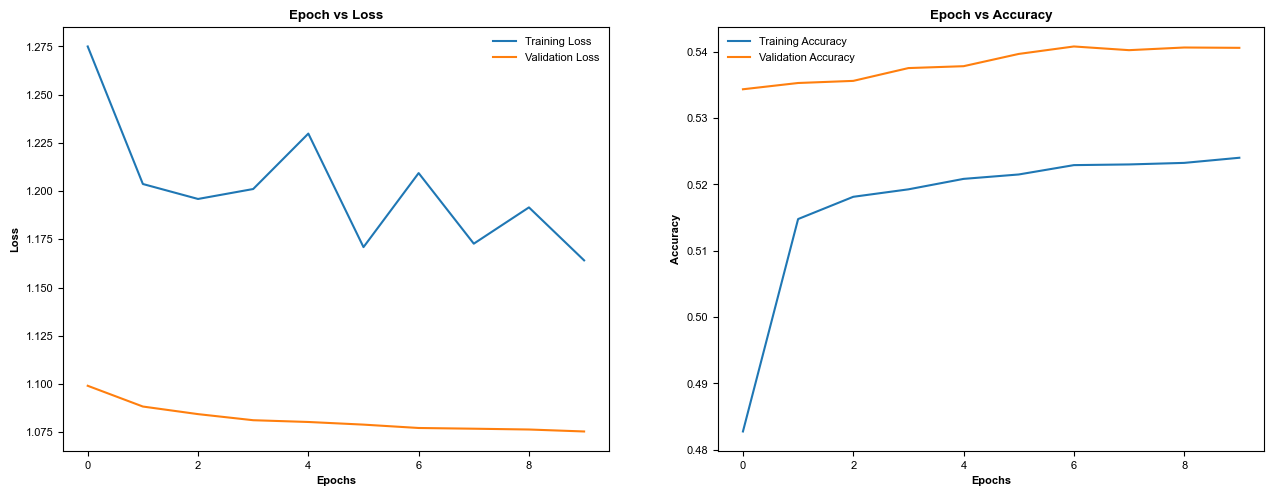

In [43]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

### Final accuracy on validation set

In [44]:
acc, cmat = test(net, dev, validate_loader, 5)
print("Overall accuracy: {:.2f}%".format(acc))
cmat.numpy().astype("int")

Overall accuracy: 54.06%


array([[13725, 11555, 10976,  8515,    64],
       [ 7340, 21854,  7602,  6102,    17],
       [ 9762, 10871, 15870, 11949,    87],
       [  343,  2777,  2012, 87276,    73],
       [ 2997,  3315,  7140, 14531,   164]])

In [46]:
####################
#                  #
#  Full train set  #
#                  #
####################
tensor_X_trainfull = torch.Tensor(X.loc[:,~X.columns.isin(["Intercept"])].to_numpy()) # transform to torch tensor
tensor_y_trainfull = torch.Tensor(y["PitchResultFactorized"].to_numpy()).type(torch.LongTensor)

# Add to dataloader
trainfull_dataset = TensorDataset(tensor_X_trainfull,tensor_y_trainfull) 
trainfull_loader  = DataLoader(trainfull_dataset, 1) 

# Predict on unseen data
out1, out2 = predict(net, dev, trainfull_loader, 5)

# Add to dataframe and save
nn_predictions_fulltrain = pd.DataFrame(out1,index=X.index,columns=pitch_result_values)



### Shuffle features

In [47]:
####################
#                  #
#    SHUFFLE       #
#                  #
####################

predictors = [col for col in X_test.columns.to_list() if col!="Intercept"]
nn_shuf_acc = []
for col in predictors:
    X_shuffle = X_test[predictors].copy()
    X_shuffle[col] = np.random.permutation(X_shuffle[col])

    # Validation (I sometimes mix up the term test here too)
    # Conver to tensors
    tensor_X_shuffle = torch.Tensor(X_shuffle.to_numpy()) # transform to torch tensor

    # Add to dataloader
    shuffle_dataset = TensorDataset(tensor_X_shuffle,tensor_y_validate) 
    shuffle_loader  = DataLoader(shuffle_dataset, batch_size) 

    # Test network with shuffled features
    temp_acc, _ = test(net,dev,shuffle_loader,5)
    nn_shuf_acc.append(temp_acc)

In [48]:
pd.DataFrame({"Accuracy":nn_shuf_acc},index=predictors)

,Accuracy
C(BatterHand)[T.R],53.101975
C(PitcherHand)[T.R],52.702235
ReleaseSpeed_zscore,52.992990
SpinRate_zscore,53.806871
ReleaseSpeed_zscore:SpinRate_zscore,53.917413
ReleaseLocX_zscore,53.208235
ReleaseLocY_zscore,53.979690
ReleaseLocZ_zscore,53.877322
PitchBreakVert_zscore,51.471487
PitchBreakHorz_zscore,51.368341


# General conclusions

For this question, I decided to filter the features down to a small number relative to the original number of features. In particular, I only retained those that define the pitcher's release and the behavior of the ball, such as velocity, spin, movement, and final location. While others may be more useful in the future, this seemed like a starting point to find features that generalize to unseen data. 

I started with a multinomial regression using the features describing the ball movement as well as the handedness of the pitcher and batter. We added an interaction term since the spin and velocity are heavily confounded. The first thing we observed is that the severe imbalance in class membership appeared to influence our predictors. While this should not impact the model weights for the predictors, it does have an effect on the intercept, which in turn is likely going to heavily bias our estimate. To remedy this we reduced the number of obsevrvations per class to acheive equal number per outcome. In doing so, we did improve the overall prediction; however, with an accuracy of only ~$25\%$, this is unlikely much higher than chance (not tested here).

From here, we moved on to implementing off-the-shelf machine learning models. Initial tests revelaed that with a small number of samples, a support vector machine (SVM), a random forest classifier, and histogram-based gradient boosted trees,  all achieved accuracies around ~$50-55\%$. However, with the dataset being so large, the training of the SVM and the gradient-boosted trees became intractable on my machine and resulted in kernel failure. Thus only the random forest was evaluated on a larger portion of the training set, which achieved an accuracy of $50%$ on the vaidation set (cut from the training set, not the hold out set).

Finally, we trained a neural network to see how the performance compared to the other methods. In addition, we added batch normalization and dropout to the network. We observed an accuracy of ~$54\%$ on the validation set, which is comparable to the other random forest model.

To evaluate the feature importance, we implemented a simple method inspired by [this book on interpretable machine learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html), where we simply shuffle one of the features and compute the accuracy on the test set. From the book:
>The concept is really straightforward: We measure the importance of a feature by calculating the increase in the model’s prediction error after permuting the feature. A feature is “important” if shuffling its values increases the model error, because in this case the model relied on the feature for the prediction. A feature is “unimportant” if shuffling its values leaves the model error unchanged, because in this case the model ignored the feature for the prediction. 

Interestingly, for both the random forest and the neural network, the most important features are where the ball is in the zone. In some sense, this makes perfect sense. For example, one thing that may be implicit in our model is that the pitcher purposefully pitches to the batter's cold zone to increase the probability of a swing and miss. However, we don't model this directly so it is difficult to know. Despite the other features appearing "unimportant", it is highly unlikely that the other parameters of the pitch, such as spin, velocity, and resulting movement are not important for this. This tells me that we are not properly modeling the data generating process and need to revisit our approach. 


# Future Work

I think the next direction to go is to build a Bayesian model to remedy the issues faced by both the logistic regression model and the machine learning approaches. In this approach, we place priors over each of parameters and obtain disributions over the outcomes, thus allowing us model the uncertainty in the system. Furthermore, we are able to leverage a huge strength of Bayesian modeling that we did not have before. We can develop a partial-pooling hierarhical model over each of the pitchers. Here, we can build pitcher specific models, but instead of modeling their data independently, we assume that they fall within some range, as defined by our priors. The advantage is that for pitchers with many observations, the model is likely to trust the data. However, for those with few observations, we automatically shrink them toward the mean, thus improving our overall estimate for each. In addition, we can take more time to think about the generating process and intellegently select which features are likely to have the most impact on swing and miss capability. We can achieve this on the front end by performing prior predictive checks to make sure our priors accurately capturing the expected behavior of the model. On the back end, we can peform posterior predictive checks to ensure that the parameters of our model our generating data that fit our expectations of our observations. 

# Bayesian Multinomial Logistic Regression

In [50]:
# Zero here since we will standardize and don't want to impact the constant
fml = 'PitchResultFactorized ~  1 + C(BatterHand) + C(PitcherHand) +  ReleaseSpeed_zscore*SpinRate_zscore + ReleaseLocX_zscore + ReleaseLocY_zscore + ReleaseLocZ_zscore + PitchBreakVert_zscore + PitchBreakHorz_zscore + PlateLocX_zscore + PlateLocZ_zscore'

# Dmatrix based on formula
y, X_centered = dmatrices(fml, trim2, return_type='dataframe')
X_centered

# Train test split 
train_indices  = [] 

n_sample = 115_000  # ~80% of the smallest class
grouped = trim.groupby(by="PitchResult")
for result in pitch_result_values:
    _local = grouped.get_group(result)
    train_indices.extend(np.random.choice(_local.index,n_sample))

test_indices = np.array(list(set(trim2.index.tolist()) - set(train_indices)))
train_indices = np.array(train_indices)

# Get train/test data
y_train, X_train = y.loc[train_indices,:].copy(), X_centered.loc[train_indices,:].copy()
y_test , X_test  = y.loc[test_indices ,:].copy(), X_centered.loc[test_indices ,:].copy()

In [52]:
import pymc as pm

In [69]:
with pm.Model() as model:
    # Make data mutable
    dataobj = pm.MutableData("dataobj",X_train.loc[:,~X_train.columns.isin(["Intercept"])].to_numpy())
    # Make intercept
    intercept = pm.Normal("intercept",mu=0,sigma=10)
    # Genereate betas size of columns
    betas = pm.Normal("betas",mu=0,sigma=10,shape=len(X_train.columns)-1)